正确分类: 5


/var/folders/xz/hx0fdggx1yd005l9y1x7hszw0000gn/T/ipykernel_36279/3186586352.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'

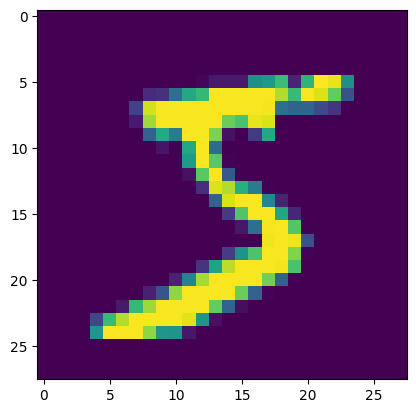

tensor([[-0.0616, -0.0614, -0.7257,  0.3332, -0.3339,  0.9897,  0.0190, -0.0621,
         -0.0435, -0.0122]])
CLIP分类: 5


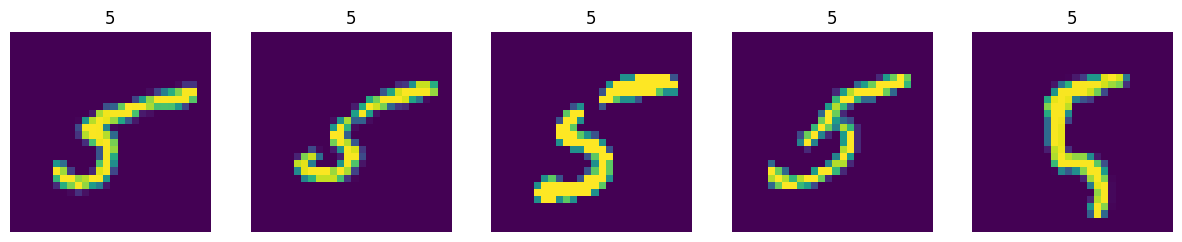


在整个MNIST数据集上评估CLIP模型性能:


100%|██████████| 60000/60000 [00:10<00:00, 5705.29it/s]

模型在MNIST数据集上的总体准确率: 96.41%
正确预测: 57847/60000

各数字类别的准确率:
数字 0: 96.72% (5729/5923)
数字 1: 99.32% (6696/6742)
数字 2: 95.20% (5672/5958)
数字 3: 94.67% (5804/6131)
数字 4: 96.95% (5664/5842)
数字 5: 95.57% (5181/5421)
数字 6: 96.98% (5739/5918)
数字 7: 96.42% (6041/6265)
数字 8: 97.15% (5684/5851)
数字 9: 94.76% (5637/5949)


In [1]:
'''
CLIP能力演示

1、对图片做分类
2、对图片求相图片

'''

from dataset import MNIST
import matplotlib.pyplot as plt
import torch
from clip import CLIP
import torch.nn.functional as F

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'   # 设备

dataset=MNIST() # 数据集

model=CLIP().to(DEVICE) # 模型
model.load_state_dict(torch.load('model.pth'))

model.eval()    # 预测模式

'''
1、对图片分类
'''
image,label=dataset[0]
print('正确分类:',label)
plt.imshow(image.permute(1,2,0))
plt.show()


### TODO: TASK 3: 完成CLIP模型进行预测的代码 (BEGIN)

with torch.no_grad():
    # 为每个数字(0-9)生成文本嵌入
    all_text_embeddings = model.text_enc(torch.arange(10).to(DEVICE))
    # 获取图像嵌入
    image_embedding = model.img_enc(image.unsqueeze(0).to(DEVICE))

    # 规范化嵌入
    image_embedding = image_embedding / image_embedding.norm(dim=1, keepdim=True)
    all_text_embeddings = all_text_embeddings / all_text_embeddings.norm(dim=1, keepdim=True)

    # 计算相似度
    similarity = torch.mm(image_embedding, all_text_embeddings.t())
    print(similarity)

    # 选择相似度最高的作为预测结果
    predicted_label = similarity.argmax(dim=1).item()

### TODO: TASK 3: 完成CLIP模型进行预测的代码 (END)

print('CLIP分类:', predicted_label)

'''
2、图像相似度
'''
other_images=[]
other_labels=[]
for i in range(1,101):
    other_image,other_label=dataset[i]
    other_images.append(other_image)
    other_labels.append(other_label)

### TODO: TASK 4: 使用CLIP的image encoder，从other_images里检索和image最相似的5张图像 (BEGIN)

with torch.no_grad():
    # 将其他图像转换为张量
    other_images_tensor = torch.stack(other_images).to(DEVICE)

    # 使用图像编码器获取图像嵌入
    query_embedding = model.img_enc(image.unsqueeze(0).to(DEVICE))
    other_embeddings = model.img_enc(other_images_tensor)

    # 规范化嵌入
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    other_embeddings = other_embeddings / other_embeddings.norm(dim=1, keepdim=True)

    # 计算相似度
    similarities = torch.mm(query_embedding, other_embeddings.t())

    # 获取相似度最高的5个索引
    indexs = similarities[0].topk(5).indices.cpu().numpy().tolist()

### TODO: TASK 4: 使用CLIP的image encoder，从other_images里检索和image最相似的5张图像 (END)

plt.figure(figsize=(15,15))
for i,img_idx in enumerate(indexs):
    plt.subplot(1,5,i+1)
    plt.imshow(other_images[img_idx].permute(1,2,0))
    plt.title(other_labels[img_idx])
    plt.axis('off')
plt.savefig(f"output/similarity{label}.pdf")
plt.show()

# 在文件末尾添加

'''
3、在整个MNIST数据集上评估CLIP模型性能
'''
print("\n在整个MNIST数据集上评估CLIP模型性能:")

# 使用tqdm创建进度条(如果没有安装可以使用pip install tqdm安装)
from tqdm import tqdm

correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    # 为每个数字(0-9)生成文本嵌入(只需计算一次)
    all_text_embeddings = model.text_enc(torch.arange(10).to(DEVICE))
    all_text_embeddings = all_text_embeddings / all_text_embeddings.norm(dim=1, keepdim=True)
    
    # 遍历数据集中的所有样本
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        
        # 获取图像嵌入
        image_embedding = model.img_enc(image.unsqueeze(0).to(DEVICE))
        image_embedding = image_embedding / image_embedding.norm(dim=1, keepdim=True)
        
        # 计算相似度
        similarity = torch.mm(image_embedding, all_text_embeddings.t())
        
        # 选择相似度最高的作为预测结果
        predicted_label = similarity.argmax(dim=1).item()
        
        # 统计正确预测的数量
        total += 1
        if predicted_label == label:
            correct += 1
            class_correct[label] += 1
        class_total[label] += 1

# 计算并打印总体准确率
accuracy = 100 * correct / total
print(f'模型在MNIST数据集上的总体准确率: {accuracy:.2f}%')
print(f'正确预测: {correct}/{total}')

# 打印每个类别的准确率
print("\n各数字类别的准确率:")
for i in range(10):
    class_acc = 100 * class_correct[i] / class_total[i]
    print(f'数字 {i}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')